In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import scipy.spatial as sp
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

In [2]:
sns.set(style='white', rc={'figure.figsize':(14,8)}) #24,8 for big one
plt.rcParams.update({'font.size': 42})

MICRO_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 26
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MICRO_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## Dataset

In [4]:
#create custom dataset class

class MyDataset(Dataset):  
    def __init__(self, data, target, transform=None, flatten=False):
        if flatten:
            data = np.reshape(data, [-1, 28*28])
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
    
        if self.transform:
            x = self.transform(x)      
        return x,y
  
    def __len__(self):
        return len(self.data)

## Networks

In [5]:
class Network(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        
        self.hidden = nn.Linear(784, n_hidden)
        self.output = nn.Linear(n_hidden, 10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x) 
        return x

In [6]:
class NetworkConv(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_hidden, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n_hidden, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(2592, 10)
        self.softmax = nn.Softmax(dim=1)
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 2592)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

## Transforms

In [7]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [8]:
transform_noisy=transforms.Compose([
    #transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

In [9]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Diversification functions

In [10]:
# negative correlation for weights in layer

def div_nc(weights, gamma = 1): #pass layer weights and gamma parameter here
    tensor_sum = 0.0
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):      
        tensor_sum += weights[i]
        tensor_mean = tensor_sum/len(weights)
    
    for i in range(len(weights)):     
        tensor_sum_nc += torch.abs(torch.mean(((tensor_mean)**2 - (weights[i])**2)))
   
    loss = gamma*tensor_sum_nc
    return loss

In [11]:
#cosine similarity diversification (each with each - quadratic O)

def div_cosine(weights, gamma = 1):  
    tensor_sum = torch.zeros([len(weights[0])])
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):
        for j in range(len(weights)):
            tensor_sum_nc += torch.mean(F.cosine_similarity(weights[i],
                                                            weights[j],
                                                            0))
    
    loss = gamma*tensor_sum_nc
    return loss

In [12]:
#cosine similarity diversification (each with mean - linear O)

def div_cosine_lin(weights, gamma = 1): #pass layer weights and gamma parameter here
    tensor_sum = 0.0
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):      
        tensor_sum += weights[i]
        tensor_mean = tensor_sum/len(weights)
    
    for i in range(len(weights)):     
        tensor_sum_nc += torch.mean(F.cosine_similarity(tensor_mean,
                                                        weights[i],
                                                        0))
   
    loss = gamma*tensor_sum_nc
    return loss

### Test functions

In [13]:
model = Network(32).to(device)

In [14]:
modelConv = NetworkConv(16).to(device)

In [15]:
#DNN test
print(div_cosine(model.hidden.weight))
print(div_cosine_lin(model.hidden.weight))
print(div_nc(model.hidden.weight))

tensor(30.8090, grad_fn=<MulBackward0>)
tensor(5.5499, grad_fn=<MulBackward0>)
tensor(0.0131, grad_fn=<MulBackward0>)


In [16]:
#CNN test
print(div_cosine(modelConv.conv2.weight))
print(div_cosine_lin(modelConv.conv2.weight))
print(div_nc(modelConv.conv2.weight))

tensor(22.5361, grad_fn=<MulBackward0>)
tensor(4.6069, grad_fn=<MulBackward0>)
tensor(0.0724, grad_fn=<MulBackward0>)


# Train NN

In [17]:
def train(model, device, train_loader, optimizer, epoch, layer, gamma=0.0, diversity = "nc"):
    model.train()
    train_loss = 0
    train_correct = 0
    # mean and standard deviation
    train_mean = 0
    train_std = 0
    #diversification and loss separately
    gamma_monitor = 0
    loss_monitor = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if diversity == 'nc':
            loss = criterion(output, target) + div_nc(layer, gamma)
        elif diversity == 'cosine':
            loss = criterion(output, target) + div_cosine(layer, gamma)
        elif diversity == 'cosine_lin':
            loss = criterion(output, target) + div_cosine_lin(layer, gamma)
        elif diversity == 'none':
            loss = criterion(output, target)
            gamma = 1
        #loss = conv_nc_2(model.hidden.weight, gamma)
        #print(model.hidden.weight.mean()*1000)
        train_mean += model.hidden.weight.mean()
        train_std += model.hidden.weight.std()
        gamma_monitor += div_nc(model.hidden.weight, gamma)
        loss_monitor += criterion(output, target)
        #print(conv_nc(model.output.weight, gamma))
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_mean /= len(train_loader.dataset)
    train_std /= len(train_loader.dataset)
    gamma_monitor /= len(train_loader.dataset)
    loss_monitor /= len(train_loader.dataset)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)
        )
    )

    return 100. * train_correct / len(train_loader.dataset), train_mean, train_std, gamma_monitor, loss_monitor

In [18]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
        )
    )

    return 100. * correct / len(test_loader.dataset), test_loss

## Train DNN (Fashion MNIST)

In [19]:
#download dataset from another library (keras)
from keras.datasets import mnist
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Using TensorFlow backend.


In [20]:
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))/255
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))/255

In [21]:
train_dataset = MyDataset(x_train, y_train, transform=None, flatten=True)
train_loader = DataLoader(train_dataset, batch_size = 4096*4, shuffle=True)

test_dataset = MyDataset(x_test, y_test, transform=None, flatten=True)
test_loader = DataLoader(test_dataset, batch_size = 4096*4, shuffle=False)

../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [78]:
gammas_per_neuron = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]#
#gammas_per_neuron = [0.0]#
ns = [32]

gammas = [16*(gpn/ns[0]) for gpn in gammas_per_neuron]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for i, g in enumerate(gammas):
        
        print('Gamma: ', g)

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 50
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g,
                                            diversity='nc'
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            #gamma_train.append(div_cosine(model.hidden.weight, gamma=1.0))
            loss_train.append(l_m)
            loss_test.append(tst_loss)
            
            if epoch in {1, 5, 10, 50}:
                
                #df = pd.DataFrame(np.transpose(model.hidden.weight.detach().numpy()), columns=range(1,33))
                
                print("Gamma per neuron: ", gammas_per_neuron[i])
                print("EPOCH: ", epoch)

                #corrMatrix = df.corr()
                #sns.heatmap(corrMatrix, robust=True, fmt="f", cmap='RdBu_r', vmin=-1, vmax=1)
                #clmap = sns.clustermap(corrMatrix, vmin=-1, vmax=1, robust=True, fmt="f", cmap='RdBu_r')
                #clmap.ax_row_dendrogram.set_visible(False)
                #clmap.ax_col_dendrogram.set_visible(False)
                #clmap.cax.set_visible(False)
                #plt.savefig('./figures_for_paper/corrmatrixGamma'+str(gammas_per_neuron[i])+'Epoch'+str(epoch)+'.pdf')
                #plt.show()
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Gamma:  0.0
Epoch #:  1

Train set: Average loss: 0.0002, Accuracy: 15263/60000 (25%)

Test set: Average loss: 0.0002, Accuracy: 4037/10000 (40%)

Gamma per neuron:  0.0
EPOCH:  1
Epoch #:  2

Train set: Average loss: 0.0001, Accuracy: 28424/60000 (47%)

Test set: Average loss: 0.0002, Accuracy: 5577/10000 (56%)

Epoch #:  3

Train set: Average loss: 0.0001, Accuracy: 34838/60000 (58%)

Test set: Average loss: 0.0002, Accuracy: 6049/10000 (60%)

Epoch #:  4

Train set: Average loss: 0.0001, Accuracy: 37025/60000 (62%)

Test set: Average loss: 0.0002, Accuracy: 6229/10000 (62%)

Epoch #:  5

Train set: Average loss: 0.0001, Accuracy: 37751/60000 (63%)

Test set: Average loss: 0.0002, Accuracy: 6286/10000 (63%)

Gamma per neuron:  0.0
EPOCH:  5
Epoch #:  6

Train set: Average loss: 0.0001, Accuracy: 38145/60000 (64%)

Test set: Average loss: 0.0002, Accuracy: 6386/10000 (64%)

Epoch #:  7

Train set: Average loss: 0.0001, Accuracy: 39309/60000 (66%)

Test set: Average loss: 0.0002, Accur


Train set: Average loss: 0.0001, Accuracy: 45712/60000 (76%)

Test set: Average loss: 0.0002, Accuracy: 7554/10000 (76%)

Gamma per neuron:  1e-05
EPOCH:  10
Epoch #:  11

Train set: Average loss: 0.0001, Accuracy: 46126/60000 (77%)

Test set: Average loss: 0.0002, Accuracy: 7624/10000 (76%)

Epoch #:  12

Train set: Average loss: 0.0001, Accuracy: 46451/60000 (77%)

Test set: Average loss: 0.0002, Accuracy: 7689/10000 (77%)

Epoch #:  13

Train set: Average loss: 0.0001, Accuracy: 46761/60000 (78%)

Test set: Average loss: 0.0002, Accuracy: 7724/10000 (77%)

Epoch #:  14

Train set: Average loss: 0.0001, Accuracy: 47024/60000 (78%)

Test set: Average loss: 0.0002, Accuracy: 7768/10000 (78%)

Epoch #:  15

Train set: Average loss: 0.0001, Accuracy: 47325/60000 (79%)

Test set: Average loss: 0.0002, Accuracy: 7804/10000 (78%)

Epoch #:  16

Train set: Average loss: 0.0001, Accuracy: 47570/60000 (79%)

Test set: Average loss: 0.0002, Accuracy: 7847/10000 (78%)

Epoch #:  17

Train set: 

Epoch #:  19

Train set: Average loss: 0.0001, Accuracy: 47774/60000 (80%)

Test set: Average loss: 0.0002, Accuracy: 7889/10000 (79%)

Epoch #:  20

Train set: Average loss: 0.0001, Accuracy: 47926/60000 (80%)

Test set: Average loss: 0.0002, Accuracy: 7919/10000 (79%)

Epoch #:  21

Train set: Average loss: 0.0001, Accuracy: 48087/60000 (80%)

Test set: Average loss: 0.0002, Accuracy: 7928/10000 (79%)

Epoch #:  22

Train set: Average loss: 0.0001, Accuracy: 48208/60000 (80%)

Test set: Average loss: 0.0002, Accuracy: 7964/10000 (80%)

Epoch #:  23

Train set: Average loss: 0.0001, Accuracy: 48385/60000 (81%)

Test set: Average loss: 0.0002, Accuracy: 7966/10000 (80%)

Epoch #:  24

Train set: Average loss: 0.0001, Accuracy: 48516/60000 (81%)

Test set: Average loss: 0.0002, Accuracy: 7976/10000 (80%)

Epoch #:  25

Train set: Average loss: 0.0001, Accuracy: 48586/60000 (81%)

Test set: Average loss: 0.0002, Accuracy: 8011/10000 (80%)

Epoch #:  26

Train set: Average loss: 0.0001, A


Train set: Average loss: 0.0001, Accuracy: 43072/60000 (72%)

Test set: Average loss: 0.0002, Accuracy: 7120/10000 (71%)

Epoch #:  30

Train set: Average loss: 0.0001, Accuracy: 43357/60000 (72%)

Test set: Average loss: 0.0002, Accuracy: 7165/10000 (72%)

Epoch #:  31

Train set: Average loss: 0.0001, Accuracy: 43605/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7183/10000 (72%)

Epoch #:  32

Train set: Average loss: 0.0001, Accuracy: 43658/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7195/10000 (72%)

Epoch #:  33

Train set: Average loss: 0.0001, Accuracy: 43784/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7199/10000 (72%)

Epoch #:  34

Train set: Average loss: 0.0001, Accuracy: 43838/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7203/10000 (72%)

Epoch #:  35

Train set: Average loss: 0.0001, Accuracy: 43883/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7213/10000 (72%)

Epoch #:  36

Train set: Average loss: 0.0001, Accuracy: 4394


Train set: Average loss: 0.0001, Accuracy: 49338/60000 (82%)

Test set: Average loss: 0.0002, Accuracy: 8110/10000 (81%)

Epoch #:  40

Train set: Average loss: 0.0001, Accuracy: 49430/60000 (82%)

Test set: Average loss: 0.0002, Accuracy: 8109/10000 (81%)

Epoch #:  41

Train set: Average loss: 0.0001, Accuracy: 49443/60000 (82%)

Test set: Average loss: 0.0002, Accuracy: 8115/10000 (81%)

Epoch #:  42

Train set: Average loss: 0.0001, Accuracy: 49487/60000 (82%)

Test set: Average loss: 0.0002, Accuracy: 8121/10000 (81%)

Epoch #:  43

Train set: Average loss: 0.0001, Accuracy: 49484/60000 (82%)

Test set: Average loss: 0.0002, Accuracy: 8123/10000 (81%)

Epoch #:  44

Train set: Average loss: 0.0001, Accuracy: 49550/60000 (83%)

Test set: Average loss: 0.0002, Accuracy: 8132/10000 (81%)

Epoch #:  45

Train set: Average loss: 0.0001, Accuracy: 49567/60000 (83%)

Test set: Average loss: 0.0002, Accuracy: 8143/10000 (81%)

Epoch #:  46

Train set: Average loss: 0.0001, Accuracy: 4959


Train set: Average loss: 0.0001, Accuracy: 49391/60000 (82%)

Test set: Average loss: 0.0002, Accuracy: 8107/10000 (81%)

Epoch #:  50

Train set: Average loss: 0.0001, Accuracy: 49404/60000 (82%)

Test set: Average loss: 0.0002, Accuracy: 8106/10000 (81%)

Gamma per neuron:  0.1
EPOCH:  50
Gamma:  0.5
Epoch #:  1

Train set: Average loss: 0.0002, Accuracy: 12278/60000 (20%)

Test set: Average loss: 0.0002, Accuracy: 5685/10000 (57%)

Gamma per neuron:  1.0
EPOCH:  1
Epoch #:  2

Train set: Average loss: 0.0001, Accuracy: 33515/60000 (56%)

Test set: Average loss: 0.0002, Accuracy: 5765/10000 (58%)

Epoch #:  3

Train set: Average loss: 0.0001, Accuracy: 34754/60000 (58%)

Test set: Average loss: 0.0002, Accuracy: 6181/10000 (62%)

Epoch #:  4

Train set: Average loss: 0.0001, Accuracy: 38395/60000 (64%)

Test set: Average loss: 0.0002, Accuracy: 6439/10000 (64%)

Epoch #:  5

Train set: Average loss: 0.0001, Accuracy: 38710/60000 (65%)

Test set: Average loss: 0.0002, Accuracy: 6479/

In [87]:
for i, tp in enumerate(test_plots):
    print(gammas[i], np.round(np.mean(train_plots[i]), 2), np.round(np.mean(tp), 2))

0.0 74.15 74.0
5e-06 77.42 77.11
5e-05 76.46 76.36
0.0005 75.47 75.75
0.005 74.16 74.07
0.05 75.39 75.37
0.5 68.25 68.43


In [88]:
df_train_7 = pd.DataFrame(np.transpose(np.asarray(train_plots))).rename(columns={0:'0.0',
                                                                               1:'0.00001',
                                                                               2:'0.0001',
                                                                               3:'0.001',
                                                                               4:'0.01',
                                                                               5:'0.1',
                                                                               6:'1.0'})
df_test_7 = pd.DataFrame(np.transpose(np.asarray(test_plots))).rename(columns={0:'0.0',
                                                                              1:'0.00001',
                                                                              2:'0.0001',
                                                                              3:'0.001',
                                                                              4:'0.01',
                                                                              5:'0.1',
                                                                              6:'1.0'})
#df_diversity = pd.DataFrame(np.transpose(np.asarray(diversity))).rename(columns={0:'0.0',
#                                                                                   1:'0.0001',
#                                                                                   2:'0.001',
#                                                                                   3:'0.01',
#                                                                                   4:'0.1',
#                                                                                   5:'1.0',
#                                                                                   6:'10.0'})

In [223]:
"""
ns = [32]
train_plots = pd.read_csv('./csvs/'+str(ns[0])+'_train_nc.csv')
test_plots = pd.read_csv('./csvs/'+str(ns[0])+'_test_nc.csv')
#diversity = pd.read_csv('./csvs/'+str(ns[0])+'_diversity_cosine.csv')
#"""

In [224]:
"""
train_plots = np.transpose(train_plots.iloc[:, 1:8].values)
test_plots = np.transpose(test_plots.iloc[:, 1:8].values)
diversity = np.transpose(diversity.iloc[:, 1:8].values)
#"""

In [89]:
df_test_7.to_csv('./csvs/'+str(ns[0])+'_test_nc_7.csv'),
df_train_7.to_csv('./csvs/'+str(ns[0])+'_train_nc_7.csv')
#df_diversity.to_csv('./csvs/'+str(ns[0])+'_diversity_cosine_lin.csv')

In [232]:
import re

In [239]:
divs = []
for ds in diversity:
    div = []
    for d in ds:
        div.append(float(d.split(",")[0].split("(")[1]))
    divs.append(div)

[[38.0328,
  32.5286,
  32.7914,
  32.9768,
  32.0475,
  30.3209,
  28.7451,
  27.6698,
  27.0278,
  26.6046,
  26.346,
  26.2514,
  26.0418,
  25.7562,
  25.3351,
  24.9644,
  24.6755,
  24.4703,
  24.3403,
  24.2712,
  24.143,
  24.0335,
  23.8936,
  23.7491,
  23.6138,
  23.492,
  23.3347,
  23.1969,
  23.0608,
  22.9033,
  22.776,
  22.689,
  22.5971,
  22.5037,
  22.4029,
  22.3318,
  22.2944,
  22.2468,
  22.2211,
  22.198,
  22.1671,
  22.147,
  22.1232,
  22.0903,
  22.0637,
  22.0413,
  22.0723,
  22.0668,
  22.0555,
  22.0557],
 [23.394,
  17.8309,
  20.3159,
  23.0141,
  22.1026,
  18.6064,
  15.2974,
  12.8419,
  11.4123,
  10.5828,
  10.3627,
  10.4288,
  10.4689,
  10.4429,
  10.4419,
  10.4193,
  10.4078,
  10.4324,
  10.4146,
  10.3777,
  10.3057,
  10.2208,
  10.1498,
  10.0038,
  9.8428,
  9.687,
  9.5074,
  9.3496,
  9.1614,
  8.9719,
  8.8423,
  8.6631,
  8.526,
  8.3652,
  8.2421,
  8.0823,
  7.8982,
  7.766,
  7.6441,
  7.5269,
  7.3923,
  7.286,
  7.1573,
  7.052

In [233]:
re.findall(r'\d+', diversity[0][0])

['38', '0328', '0']

(0, 50)

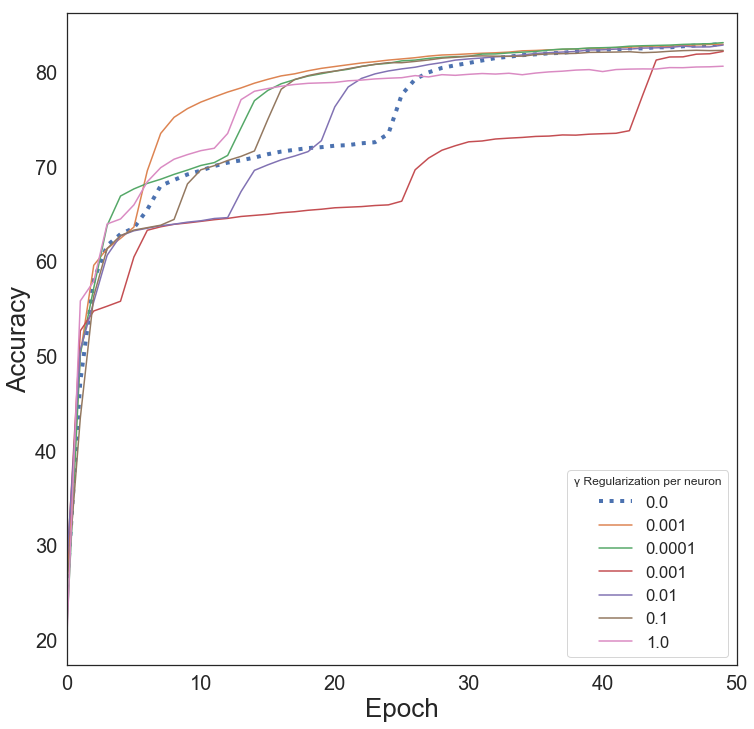

In [83]:
plt.figure(figsize=(12,12))
for i, tp in enumerate(train_plots):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.001, 0.0001, 0.001, 0.01, 0.1, 1.0],
                   title = '\u03B3 Regularization per neuron',
                   fontsize='small',
                   fancybox=True)
#plt.title('Training Accuracy DNN 1Hidden256neurons, Negative Correlation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0,50)
#plt.savefig("./figures_for_paper/lastTRAINdnnFashionMnist"+str(ns[0])+"neurCOSINE50e.pdf")
#plt.legend(handles=[one, two, three], title="title",
#                    loc=4, fontsize='small', fancybox=True)

In [29]:
str(ns[0])

'32'

(0, 50)

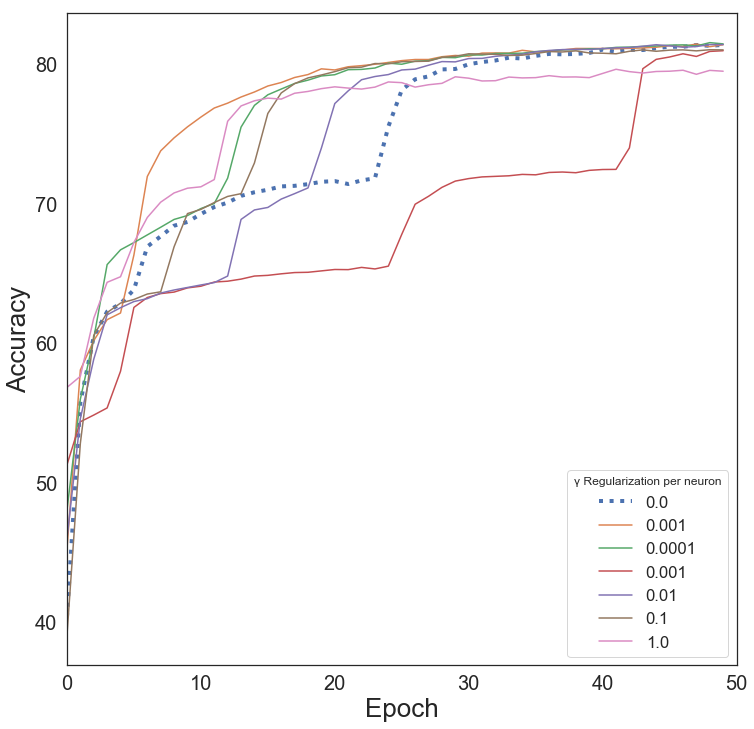

In [84]:
plt.figure(figsize=(12,12))
for i, tp in enumerate(test_plots):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.001, 0.0001, 0.001, 0.01, 0.1, 1.0],
                   title = '\u03B3 Regularization per neuron',
                   fontsize='small',
                   fancybox=True)
#plt.title('Training Accuracy DNN 1Hidden256neurons, Negative Correlation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.savefig("./figures_for_paper/newTESTdnnFashionMnist"+str(ns[0])+"neurNC50e.pdf")
plt.xlim(0,50)
#plt.legend(handles=[one, two, three], title="title",
#                    loc=4, fontsize='small', fancybox=True)

In [30]:
df_train.head()

,0.0,0.00001,0.0001,0.001,0.01,0.1,1.0
0,27.540000,31.125000,28.623333,22.413333,27.821667,28.046667,22.773333
1,48.853333,45.430000,44.783333,37.550000,50.751667,45.566667,40.021667
2,53.541667,50.673333,52.125000,43.003333,54.486667,52.770000,45.600000
3,59.476667,53.820000,60.031667,53.638333,55.500000,60.511667,52.163333
4,62.586667,60.191667,62.570000,55.428333,55.736667,62.565000,61.095000


In [31]:
df_test.head()

,0.0,0.00001,0.0001,0.001,0.01,0.1,1.0
0,47.00,44.19,42.04,37.13,47.87,42.86,38.04
1,51.35,49.69,49.03,38.16,53.18,49.66,42.23
2,57.70,52.58,58.40,52.32,55.23,58.19,49.33
3,61.77,57.87,61.34,54.93,55.52,61.81,59.92
4,62.76,64.33,63.21,55.59,55.63,62.66,61.81


In [ ]:
#pd.concat([v1, v2, v3]).groupby(level=0).mean()

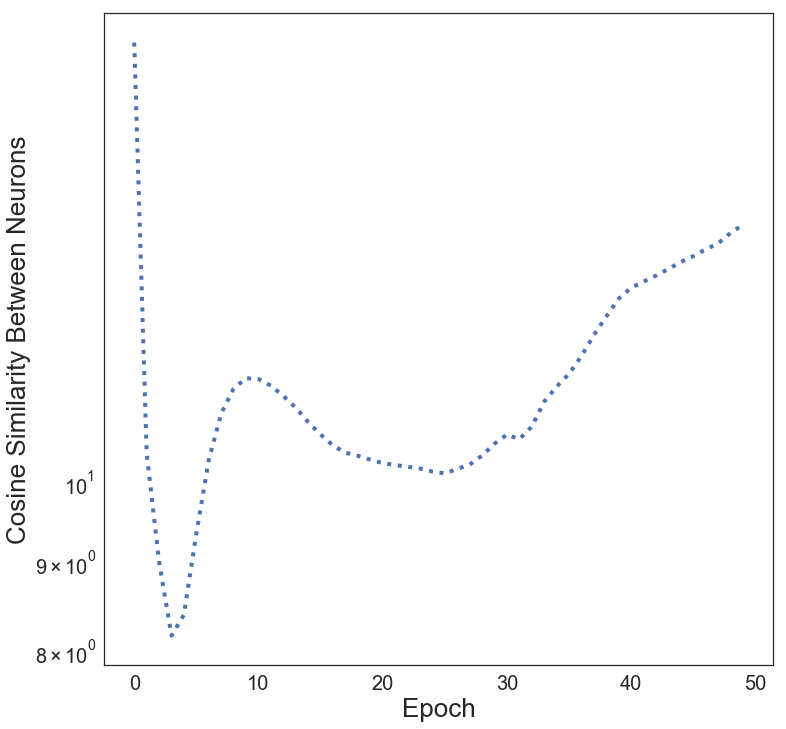

In [221]:
n_pl = 7#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(diversity[:n_pl]):
    if i == 0:
        plt.plot([p for p in tp], linewidth=4, linestyle=':')
    else:
        plt.plot([p for p in tp])
        plt.legend([0.0, 0.001/10000, 0.0001/100, 0.001/100, 0.01/100, 0.1/100, 1.0/100],
                   title = '\u03B3 Regularization per neuron',
                   fontsize='small',
                   fancybox=True)
#plt.title('Diversity Factor DNN 1Hidden32neurons, Negative Correlation')
plt.yscale('log') #
plt.ylabel('Cosine Similarity Between Neurons')
plt.xlabel('Epoch')
plt.savefig("./figures_for_paper/lastDiversityDnnFashionMnist"+str(ns[0])+"neurCOSINE50e.pdf")

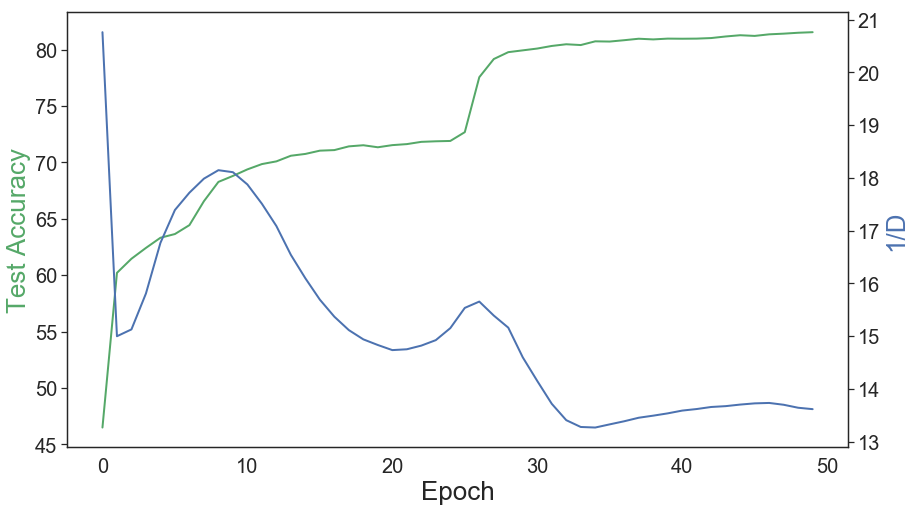

In [248]:
x = np.arange(0, 50, 1)
y1 = test_plots[0][:50]
y2 = diversity[0][:50]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-', linewidth=2)
ax2.plot(x, y2, 'b-', linewidth=2)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy', color='g')
ax2.set_ylabel('1/D', color='b')

plt.savefig("./figures_for_paper/Diversity3.pdf")

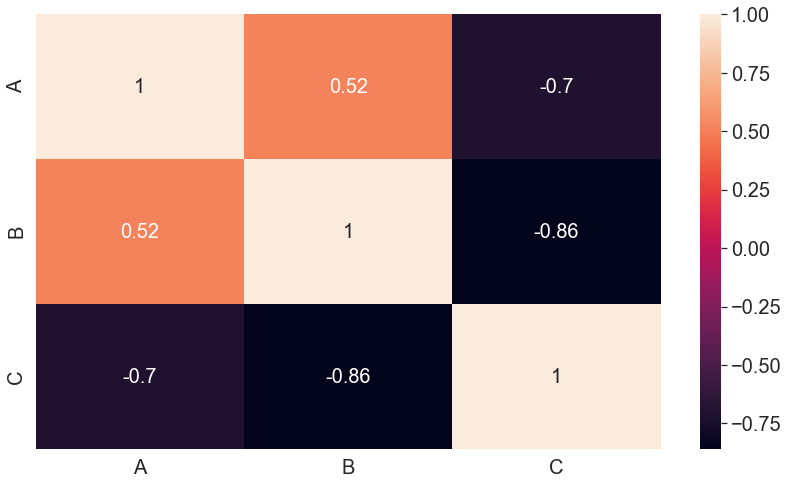

In [109]:
data = {'A': [45,37,42,35,39],
        'B': [38,31,26,28,33],
        'C': [10,15,17,21,12]
        }

df = pd.DataFrame(data,columns=['A','B','C'])

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#sns.heatmap(tiles, robust=True, fmt="f", cmap='RdBu_r', vmin=0, vmax=2)

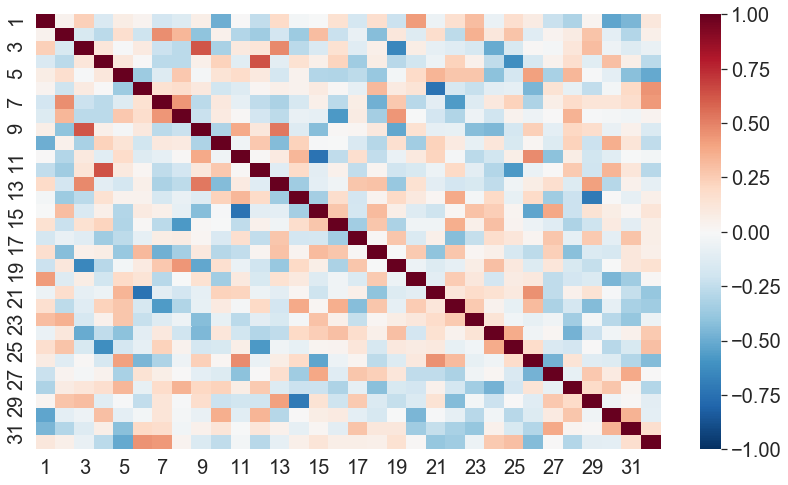

In [117]:
df = pd.DataFrame(np.transpose(model.hidden.weight.detach().numpy()), columns=range(1,33))

corrMatrix = df.corr()
sns.heatmap(corrMatrix, robust=True, fmt="f", cmap='RdBu_r', vmin=-1, vmax=1)
plt.show()

(0, 50)

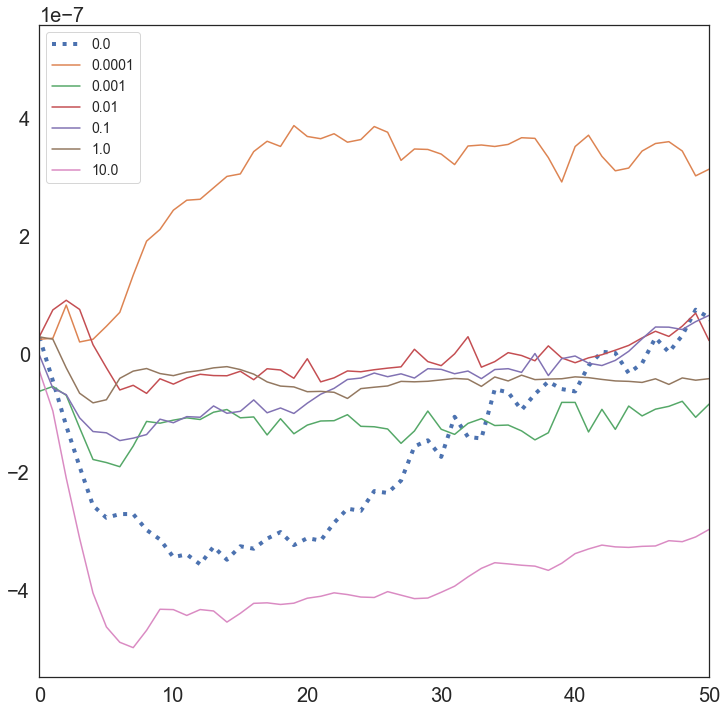

In [166]:
n_pl = 7#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(mean_all_gammas[:n_pl]):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
#plt.title('Weight Mean DNN 1Hidden32neurons, Negative Correlation')
plt.xlim(0,50)
#plt.savefig('./figures/Weight_Mean_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #

(0, 50)

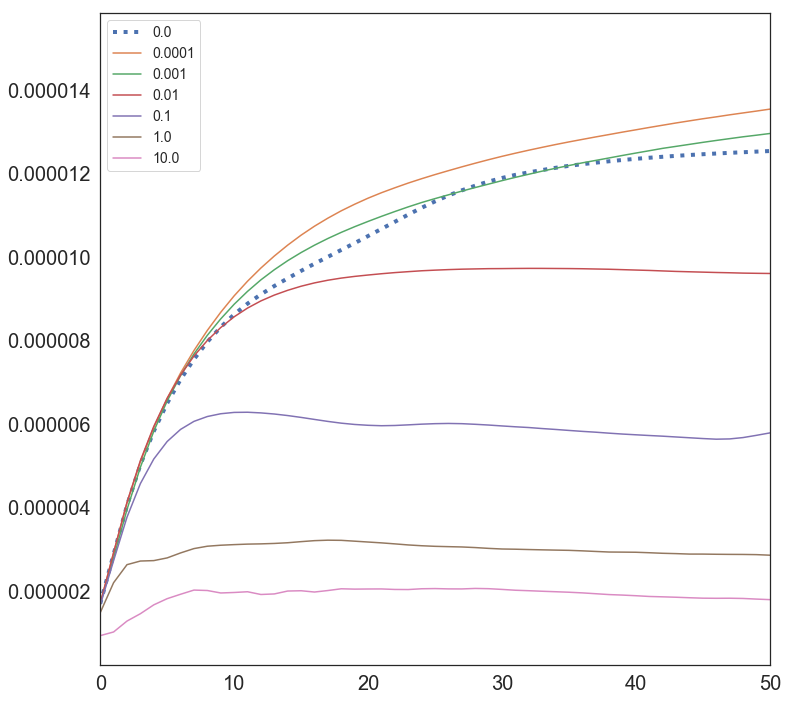

In [167]:
n_pl = 7#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(std_all_gammas[:n_pl]):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
#plt.title('Standard Deviation DNN 1Hidden32neurons, Negative Correlation')
#plt.savefig('./figures/Standard_Deviation_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #
plt.xlim(0,50)

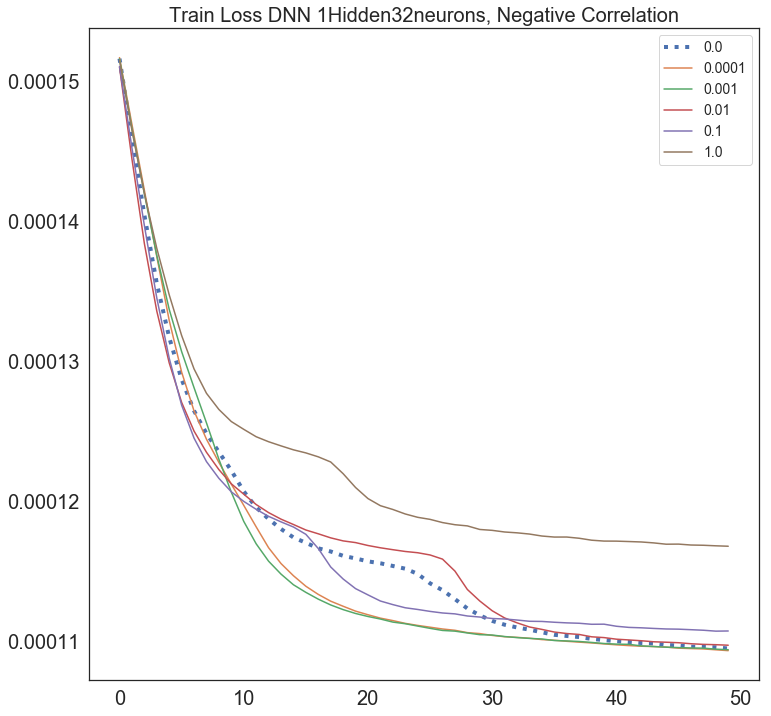

In [114]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(loss_train_all_gammas[:n_pl]):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
plt.title('Train Loss DNN 1Hidden32neurons, Negative Correlation')
plt.savefig('./figures/Train_Loss_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #

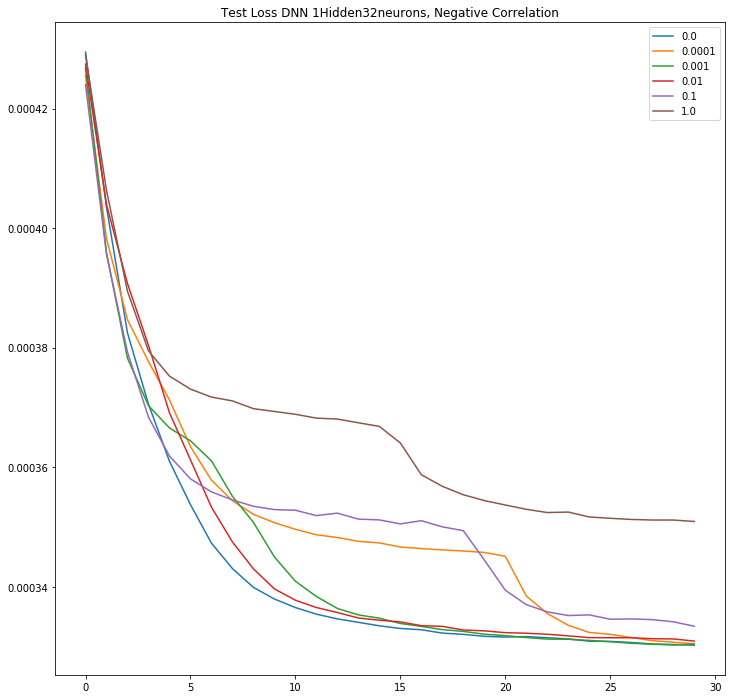

In [49]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Test Loss DNN 1Hidden32neurons, Negative Correlation')
plt.savefig('./figures/Test_Loss_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #

In [26]:
gammas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1]#
ns = [16]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in gammas:

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 30
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g,
                                            diversity='cosine'
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 14774/60000 (25%)

Test set: Average loss: 0.0004, Accuracy: 3322/10000 (33%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 25936/60000 (43%)

Test set: Average loss: 0.0004, Accuracy: 5320/10000 (53%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 33079/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5624/10000 (56%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 35612/60000 (59%)

Test set: Average loss: 0.0004, Accuracy: 6383/10000 (64%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 39522/60000 (66%)

Test set: Average loss: 0.0004, Accuracy: 6745/10000 (67%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 41157/60000 (69%)

Test set: Average loss: 0.0004, Accuracy: 6879/10000 (69%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 41689/60000 (69%)

Test set: Average loss: 0.0004, Accuracy: 6900/10000 (69%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy:


Train set: Average loss: 0.0003, Accuracy: 30334/60000 (51%)

Test set: Average loss: 0.0004, Accuracy: 5486/10000 (55%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 35397/60000 (59%)

Test set: Average loss: 0.0004, Accuracy: 6212/10000 (62%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 37807/60000 (63%)

Test set: Average loss: 0.0004, Accuracy: 6326/10000 (63%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 38196/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6368/10000 (64%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 38365/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6403/10000 (64%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 39194/60000 (65%)

Test set: Average loss: 0.0004, Accuracy: 6818/10000 (68%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy: 41650/60000 (69%)

Test set: Average loss: 0.0004, Accuracy: 6992/10000 (70%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 42185/60000


Train set: Average loss: 0.0003, Accuracy: 21019/60000 (35%)

Test set: Average loss: 0.0004, Accuracy: 3648/10000 (36%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 22773/60000 (38%)

Test set: Average loss: 0.0004, Accuracy: 3982/10000 (40%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 23339/60000 (39%)

Test set: Average loss: 0.0004, Accuracy: 4030/10000 (40%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 26180/60000 (44%)

Test set: Average loss: 0.0004, Accuracy: 4744/10000 (47%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 30746/60000 (51%)

Test set: Average loss: 0.0004, Accuracy: 5285/10000 (53%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy: 32208/60000 (54%)

Test set: Average loss: 0.0004, Accuracy: 5352/10000 (54%)

Epoch #:  9

Train set: Average loss: 0.0003, Accuracy: 32426/60000 (54%)

Test set: Average loss: 0.0004, Accuracy: 5397/10000 (54%)

Epoch #:  10

Train set: Average loss: 0.0003, Accuracy: 34328/6000

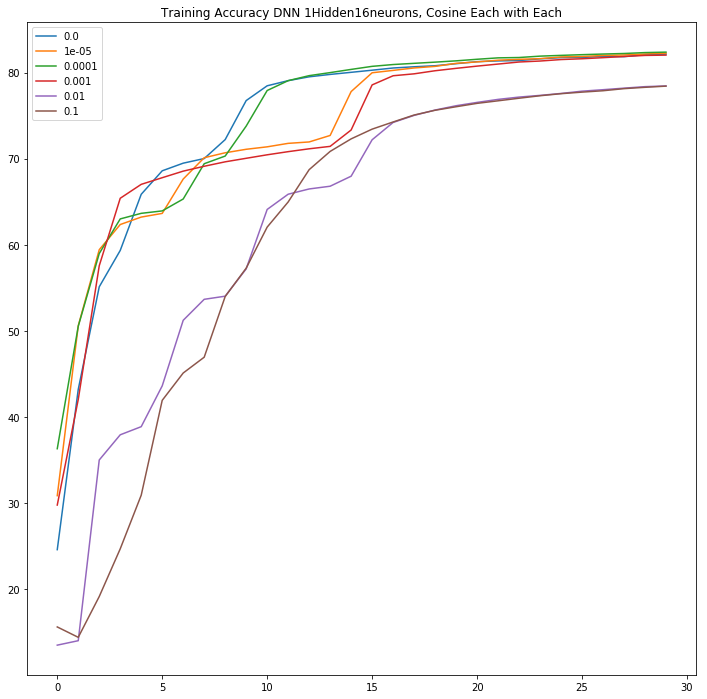

In [27]:
plt.figure(figsize=(12,12))
for tp in train_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Training Accuracy DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('./figures/Training_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')

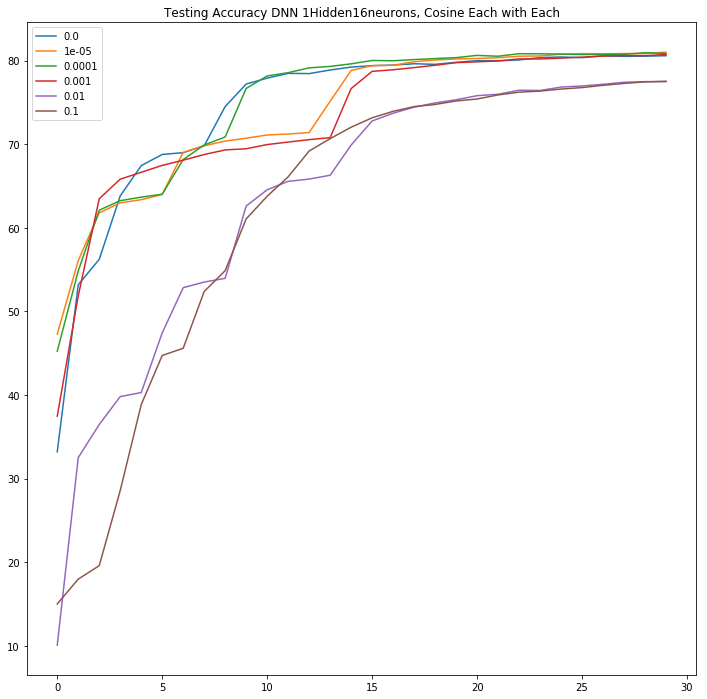

In [28]:
plt.figure(figsize=(12,12))
for tp in test_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Testing Accuracy DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('./figures/Testing_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')

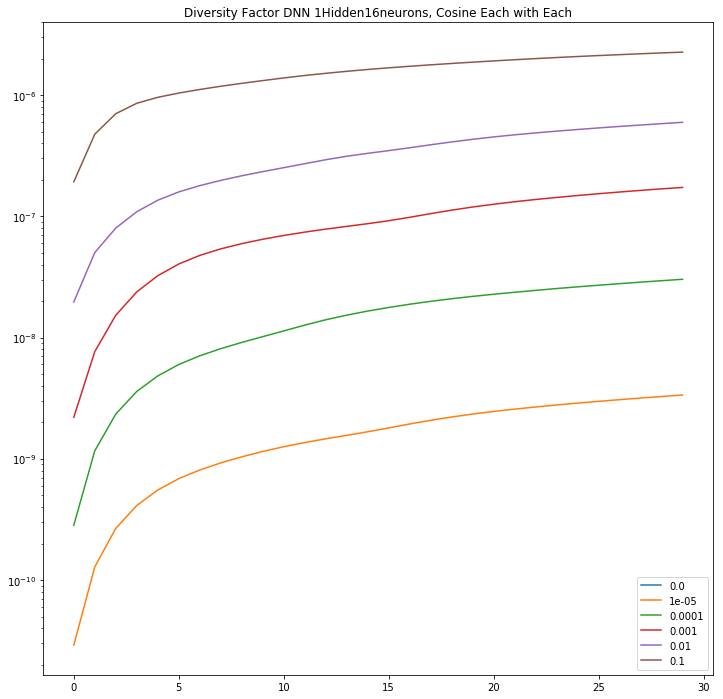

In [29]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in diversity[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Diversity Factor DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('./figures/Diversity_Factor_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
plt.yscale('log') #

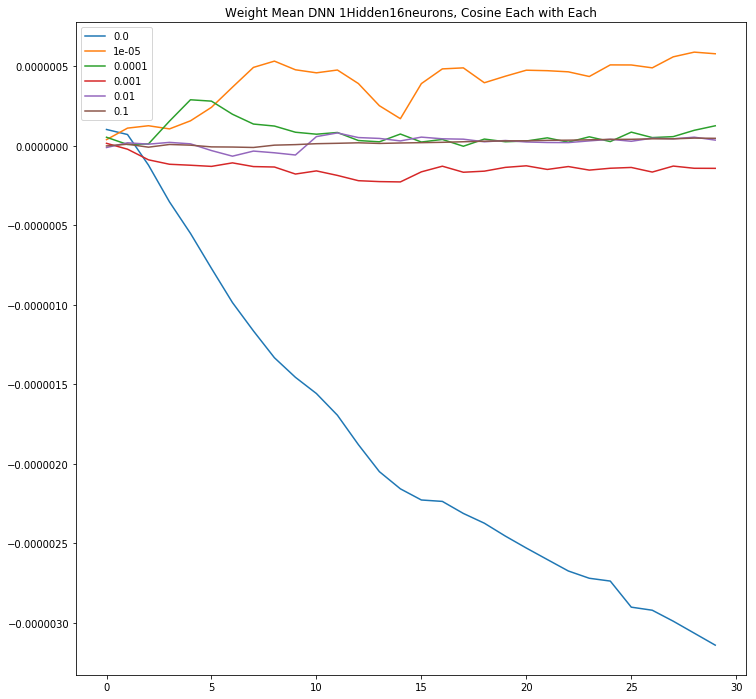

In [30]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in mean_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Weight Mean DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('./figures/Weight_Mean_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

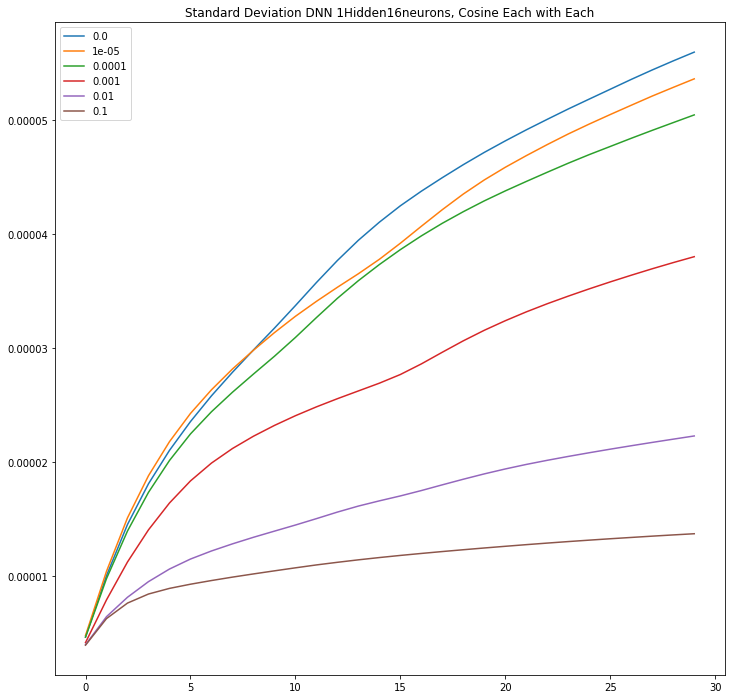

In [31]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in std_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Standard Deviation DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('./figures/Standard_Deviation_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

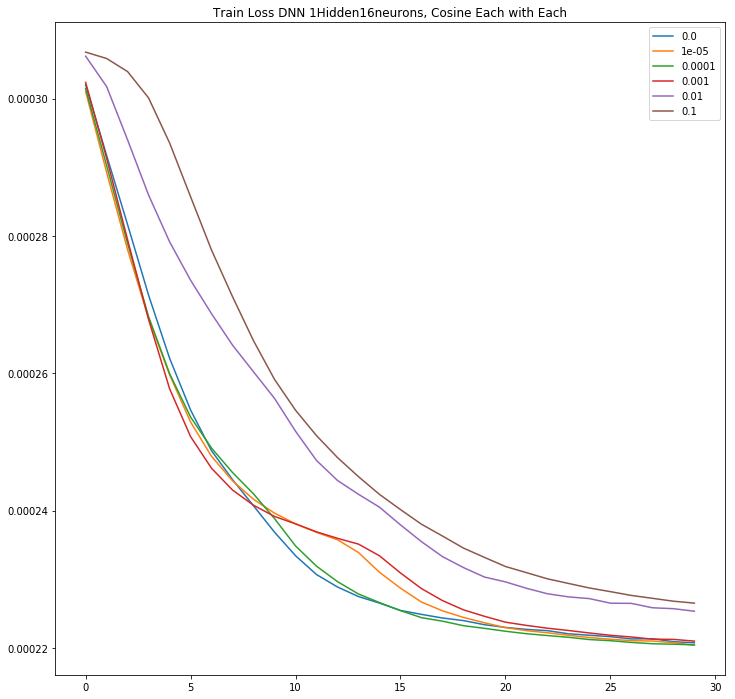

In [32]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_train_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Train Loss DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('./figures/Train_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

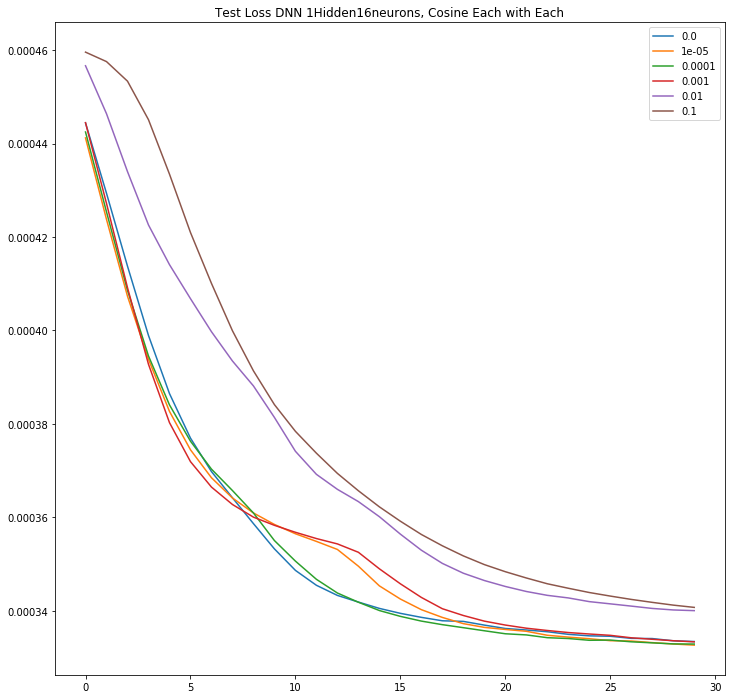

In [33]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Test Loss DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('./figures/Test_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

In [34]:
gammas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1]#
ns = [16]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in gammas:

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 30
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g,
                                            diversity='cosine_lin'
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 17509/60000 (29%)

Test set: Average loss: 0.0004, Accuracy: 4444/10000 (44%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 31763/60000 (53%)

Test set: Average loss: 0.0004, Accuracy: 6017/10000 (60%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 36360/60000 (61%)

Test set: Average loss: 0.0004, Accuracy: 6331/10000 (63%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 38624/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6502/10000 (65%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 39941/60000 (67%)

Test set: Average loss: 0.0004, Accuracy: 6701/10000 (67%)

Epoch #:  6

Train set: Average loss: 0.0002, Accuracy: 41436/60000 (69%)

Test set: Average loss: 0.0004, Accuracy: 7141/10000 (71%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 44493/60000 (74%)

Test set: Average loss: 0.0004, Accuracy: 7559/10000 (76%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy:


Train set: Average loss: 0.0003, Accuracy: 32165/60000 (54%)

Test set: Average loss: 0.0004, Accuracy: 5807/10000 (58%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 36174/60000 (60%)

Test set: Average loss: 0.0004, Accuracy: 6157/10000 (62%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 37470/60000 (62%)

Test set: Average loss: 0.0004, Accuracy: 6264/10000 (63%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 37936/60000 (63%)

Test set: Average loss: 0.0004, Accuracy: 6318/10000 (63%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 38204/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6367/10000 (64%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 38373/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6415/10000 (64%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy: 38592/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6438/10000 (64%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 38739/60000


Train set: Average loss: 0.0003, Accuracy: 21264/60000 (35%)

Test set: Average loss: 0.0004, Accuracy: 4163/10000 (42%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 26796/60000 (45%)

Test set: Average loss: 0.0004, Accuracy: 4747/10000 (47%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 30589/60000 (51%)

Test set: Average loss: 0.0004, Accuracy: 5436/10000 (54%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 34869/60000 (58%)

Test set: Average loss: 0.0004, Accuracy: 6380/10000 (64%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 39161/60000 (65%)

Test set: Average loss: 0.0004, Accuracy: 6600/10000 (66%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy: 40070/60000 (67%)

Test set: Average loss: 0.0004, Accuracy: 6666/10000 (67%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 40499/60000 (67%)

Test set: Average loss: 0.0004, Accuracy: 6724/10000 (67%)

Epoch #:  10

Train set: Average loss: 0.0002, Accuracy: 40927/6000

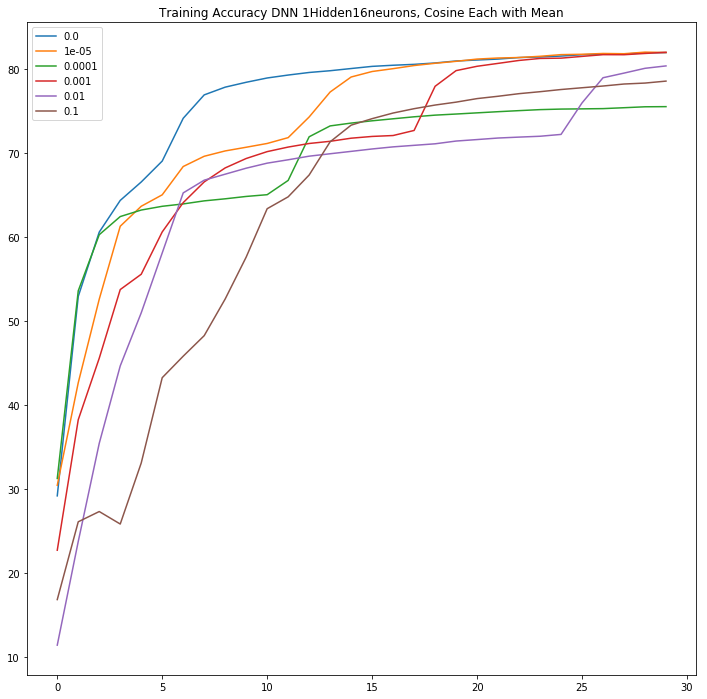

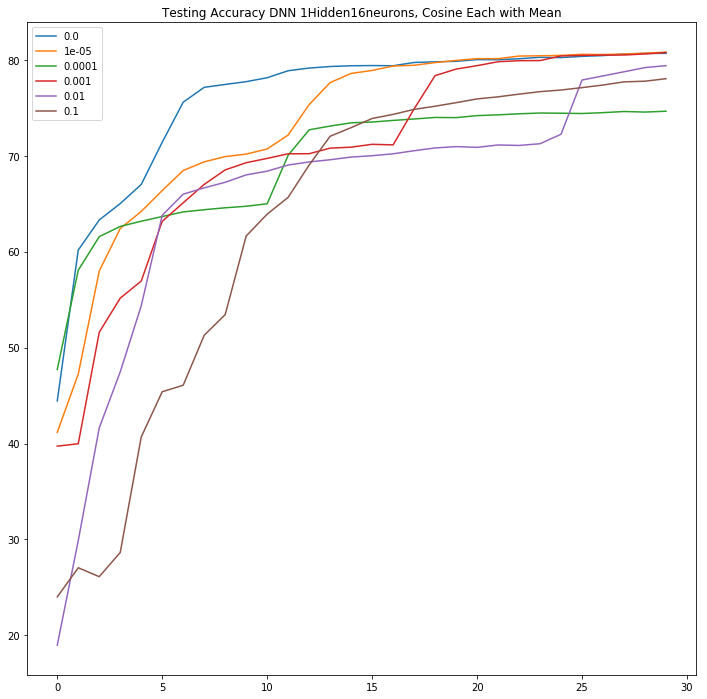

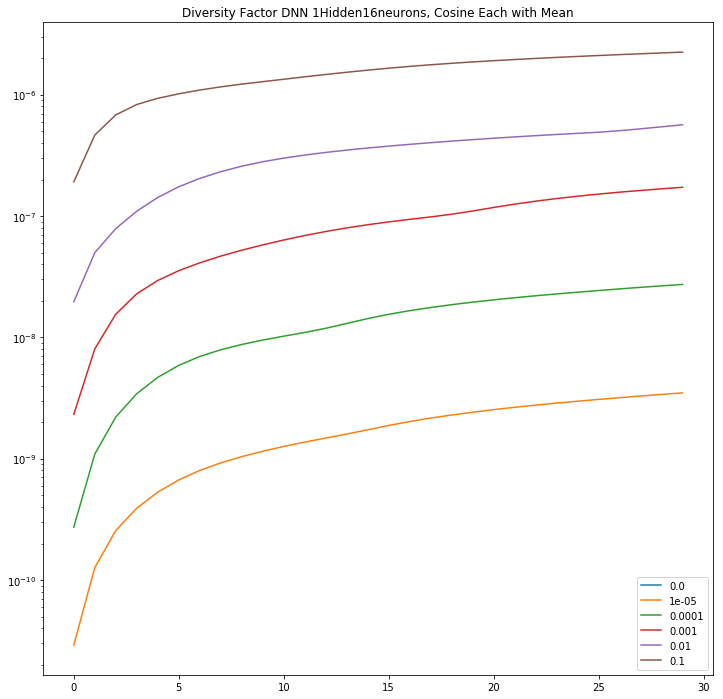

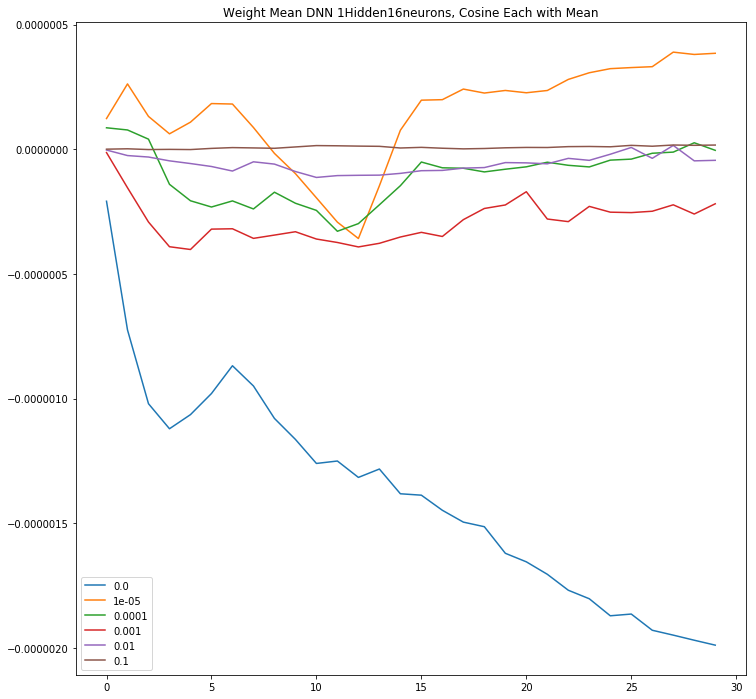

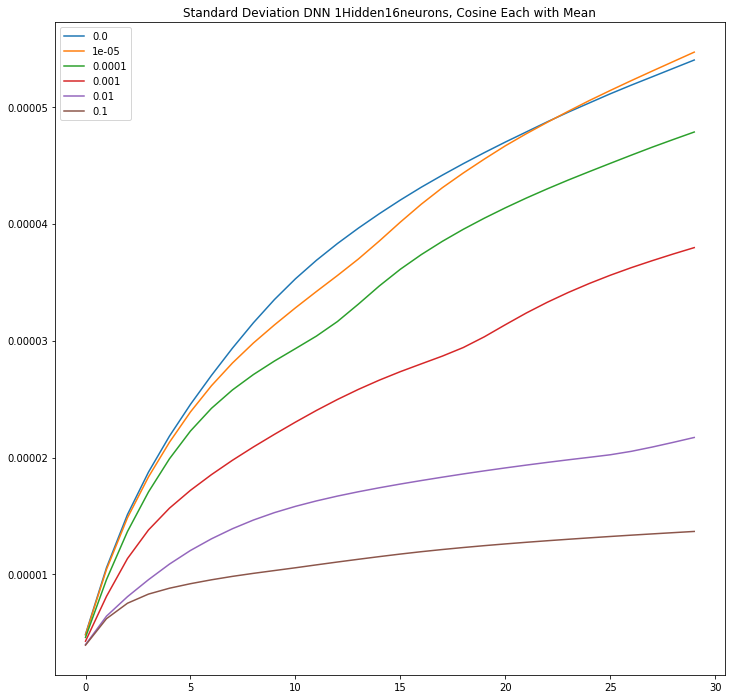

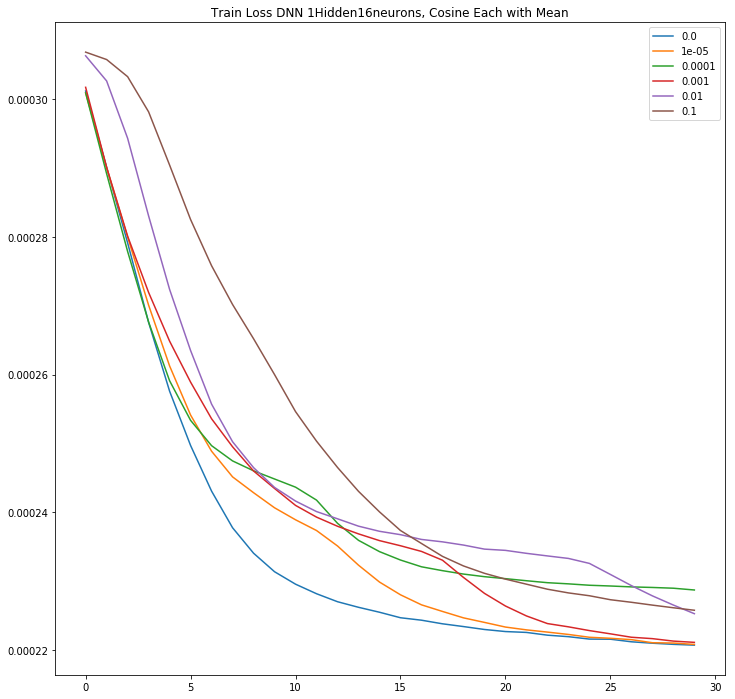

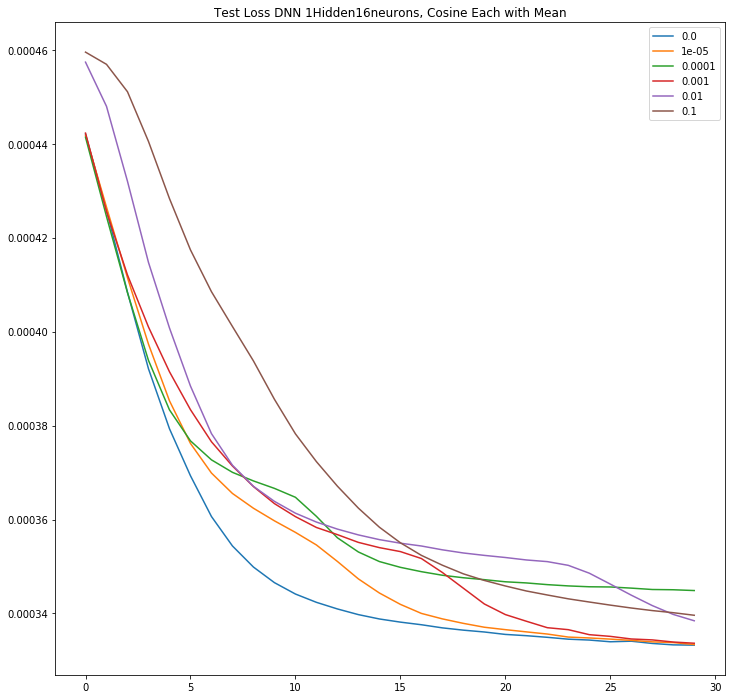

In [35]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))

for tp in train_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Training Accuracy DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('./figures/Training_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
plt.show()

plt.figure(figsize=(12,12))
for tp in test_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Testing Accuracy DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('./figures/Testing_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')

plt.figure(figsize=(12,12))
for tp in diversity[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Diversity Factor DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('./figures/Diversity_Factor_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in mean_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Weight Mean DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('./figures/Weight_Mean_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in std_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Standard Deviation DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('./figures/Standard_Deviation_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in loss_train_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Train Loss DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('./figures/Train_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Test Loss DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('./figures/Test_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

# Diversity observation without regularization

In [18]:
#gammas = [1.0]#
g = 1.0
ns = [16, 32, 64, 128, 256]

diversity_ncorr_all = []      
diversity_cosine_all = []
diversity_cosine_lin_all = []

all_train = []
all_test = []

for n in ns:

    model = Network(n).to(device) #networkSmall NetworkConv
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    epochs = 100
    gamma = 1.0

    train_acc = []
    test_acc = []

    mean = []
    std = []

    diversity_ncorr = []
    diversity_cosine = []
    diversity_cosine_lin = []

    loss_train = []
    loss_test = []
    
    #diversity_ncorr.append(div_nc(model.hidden.weight, 1.0))
    #diversity_cosine.append(div_cosine(model.hidden.weight, 1.0))
    #diversity_cosine_lin.append(div_cosine_lin(model.hidden.weight, 1.0))

    for epoch in range(1, epochs + 1):
        print('Epoch #: ', epoch)
        trn, m_m, s_m, g_m, l_m = train(model,
                                        device,
                                        train_loader,
                                        optimizer,
                                        epoch,
                                        model.hidden.weight,
                                        gamma=g,
                                        diversity='none'
                                        ) #
        tst, tst_loss = test(model, device, test_loader)

        diversity_ncorr.append(div_nc(model.hidden.weight, 1.0))        
        diversity_cosine.append(div_cosine(model.hidden.weight, 1.0))
        diversity_cosine_lin.append(div_cosine_lin(model.hidden.weight, 1.0))

        mean.append(m_m)
        std.append(s_m)

        train_acc.append(trn)
        test_acc.append(tst)
        
    diversity_ncorr_all.append(diversity_ncorr)    
    diversity_cosine_all.append(diversity_cosine)
    diversity_cosine_lin_all.append(diversity_cosine_lin)
    
    all_train.append(train_acc)
    all_test.append(test_acc)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 11751/60000 (20%)

Test set: Average loss: 0.0004, Accuracy: 3552/10000 (36%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 23681/60000 (39%)

Test set: Average loss: 0.0004, Accuracy: 4597/10000 (46%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 31215/60000 (52%)

Test set: Average loss: 0.0004, Accuracy: 5996/10000 (60%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 37981/60000 (63%)

Test set: Average loss: 0.0004, Accuracy: 6631/10000 (66%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 41343/60000 (69%)

Test set: Average loss: 0.0004, Accuracy: 7054/10000 (71%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 43525/60000 (73%)

Test set: Average loss: 0.0004, Accuracy: 7361/10000 (74%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 45135/60000 (75%)

Test set: Average loss: 0.0004, Accuracy: 7587/10000 (76%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy:


Train set: Average loss: 0.0002, Accuracy: 50215/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8169/10000 (82%)

Epoch #:  63

Train set: Average loss: 0.0002, Accuracy: 50229/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8166/10000 (82%)

Epoch #:  64

Train set: Average loss: 0.0002, Accuracy: 50216/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8170/10000 (82%)

Epoch #:  65

Train set: Average loss: 0.0002, Accuracy: 50204/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8173/10000 (82%)

Epoch #:  66

Train set: Average loss: 0.0002, Accuracy: 50262/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8164/10000 (82%)

Epoch #:  67

Train set: Average loss: 0.0002, Accuracy: 50251/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8177/10000 (82%)

Epoch #:  68

Train set: Average loss: 0.0002, Accuracy: 50286/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8159/10000 (82%)

Epoch #:  69

Train set: Average loss: 0.0002, Accuracy: 5028

Epoch #:  23

Train set: Average loss: 0.0002, Accuracy: 49436/60000 (82%)

Test set: Average loss: 0.0003, Accuracy: 8094/10000 (81%)

Epoch #:  24

Train set: Average loss: 0.0002, Accuracy: 49532/60000 (83%)

Test set: Average loss: 0.0003, Accuracy: 8118/10000 (81%)

Epoch #:  25

Train set: Average loss: 0.0002, Accuracy: 49604/60000 (83%)

Test set: Average loss: 0.0003, Accuracy: 8133/10000 (81%)

Epoch #:  26

Train set: Average loss: 0.0002, Accuracy: 49695/60000 (83%)

Test set: Average loss: 0.0003, Accuracy: 8140/10000 (81%)

Epoch #:  27

Train set: Average loss: 0.0002, Accuracy: 49727/60000 (83%)

Test set: Average loss: 0.0003, Accuracy: 8144/10000 (81%)

Epoch #:  28

Train set: Average loss: 0.0002, Accuracy: 49759/60000 (83%)

Test set: Average loss: 0.0003, Accuracy: 8158/10000 (82%)

Epoch #:  29

Train set: Average loss: 0.0002, Accuracy: 49813/60000 (83%)

Test set: Average loss: 0.0003, Accuracy: 8171/10000 (82%)

Epoch #:  30

Train set: Average loss: 0.0002, A

Epoch #:  84

Train set: Average loss: 0.0002, Accuracy: 51093/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8248/10000 (82%)

Epoch #:  85

Train set: Average loss: 0.0002, Accuracy: 51162/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8254/10000 (83%)

Epoch #:  86

Train set: Average loss: 0.0002, Accuracy: 51180/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8242/10000 (82%)

Epoch #:  87

Train set: Average loss: 0.0002, Accuracy: 51108/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8248/10000 (82%)

Epoch #:  88

Train set: Average loss: 0.0002, Accuracy: 51194/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8248/10000 (82%)

Epoch #:  89

Train set: Average loss: 0.0002, Accuracy: 51225/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8243/10000 (82%)

Epoch #:  90

Train set: Average loss: 0.0002, Accuracy: 51263/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8250/10000 (82%)

Epoch #:  91

Train set: Average loss: 0.0002, A

Test set: Average loss: 0.0003, Accuracy: 8250/10000 (82%)

Epoch #:  45

Train set: Average loss: 0.0002, Accuracy: 50887/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8270/10000 (83%)

Epoch #:  46

Train set: Average loss: 0.0002, Accuracy: 50867/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8242/10000 (82%)

Epoch #:  47

Train set: Average loss: 0.0002, Accuracy: 50884/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8264/10000 (83%)

Epoch #:  48

Train set: Average loss: 0.0002, Accuracy: 50905/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8256/10000 (83%)

Epoch #:  49

Train set: Average loss: 0.0002, Accuracy: 50915/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8256/10000 (83%)

Epoch #:  50

Train set: Average loss: 0.0002, Accuracy: 50957/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8258/10000 (83%)

Epoch #:  51

Train set: Average loss: 0.0002, Accuracy: 50989/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8271/1

Epoch #:  5

Train set: Average loss: 0.0002, Accuracy: 42311/60000 (71%)

Test set: Average loss: 0.0004, Accuracy: 7063/10000 (71%)

Epoch #:  6

Train set: Average loss: 0.0002, Accuracy: 42777/60000 (71%)

Test set: Average loss: 0.0004, Accuracy: 7094/10000 (71%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 43018/60000 (72%)

Test set: Average loss: 0.0003, Accuracy: 7120/10000 (71%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy: 43223/60000 (72%)

Test set: Average loss: 0.0003, Accuracy: 7139/10000 (71%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 43427/60000 (72%)

Test set: Average loss: 0.0003, Accuracy: 7154/10000 (72%)

Epoch #:  10

Train set: Average loss: 0.0002, Accuracy: 43562/60000 (73%)

Test set: Average loss: 0.0003, Accuracy: 7184/10000 (72%)

Epoch #:  11

Train set: Average loss: 0.0002, Accuracy: 43742/60000 (73%)

Test set: Average loss: 0.0003, Accuracy: 7191/10000 (72%)

Epoch #:  12

Train set: Average loss: 0.0002, Accura

Epoch #:  66

Train set: Average loss: 0.0002, Accuracy: 51612/60000 (86%)

Test set: Average loss: 0.0003, Accuracy: 8295/10000 (83%)

Epoch #:  67

Train set: Average loss: 0.0002, Accuracy: 51647/60000 (86%)

Test set: Average loss: 0.0003, Accuracy: 8298/10000 (83%)

Epoch #:  68

Train set: Average loss: 0.0002, Accuracy: 51659/60000 (86%)

Test set: Average loss: 0.0003, Accuracy: 8303/10000 (83%)

Epoch #:  69

Train set: Average loss: 0.0002, Accuracy: 51687/60000 (86%)

Test set: Average loss: 0.0003, Accuracy: 8306/10000 (83%)

Epoch #:  70

Train set: Average loss: 0.0002, Accuracy: 51697/60000 (86%)

Test set: Average loss: 0.0003, Accuracy: 8304/10000 (83%)

Epoch #:  71

Train set: Average loss: 0.0002, Accuracy: 51662/60000 (86%)

Test set: Average loss: 0.0003, Accuracy: 8303/10000 (83%)

Epoch #:  72

Train set: Average loss: 0.0002, Accuracy: 51694/60000 (86%)

Test set: Average loss: 0.0003, Accuracy: 8308/10000 (83%)

Epoch #:  73

Train set: Average loss: 0.0002, A

Epoch #:  27

Train set: Average loss: 0.0002, Accuracy: 50462/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8228/10000 (82%)

Epoch #:  28

Train set: Average loss: 0.0002, Accuracy: 50483/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8253/10000 (83%)

Epoch #:  29

Train set: Average loss: 0.0002, Accuracy: 50552/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8250/10000 (82%)

Epoch #:  30

Train set: Average loss: 0.0002, Accuracy: 50608/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8229/10000 (82%)

Epoch #:  31

Train set: Average loss: 0.0002, Accuracy: 50665/60000 (84%)

Test set: Average loss: 0.0003, Accuracy: 8251/10000 (83%)

Epoch #:  32

Train set: Average loss: 0.0002, Accuracy: 50720/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8273/10000 (83%)

Epoch #:  33

Train set: Average loss: 0.0002, Accuracy: 50724/60000 (85%)

Test set: Average loss: 0.0003, Accuracy: 8268/10000 (83%)

Epoch #:  34

Train set: Average loss: 0.0002, A

Test set: Average loss: 0.0003, Accuracy: 8356/10000 (84%)

Epoch #:  88

Train set: Average loss: 0.0002, Accuracy: 52087/60000 (87%)

Test set: Average loss: 0.0003, Accuracy: 8376/10000 (84%)

Epoch #:  89

Train set: Average loss: 0.0002, Accuracy: 52121/60000 (87%)

Test set: Average loss: 0.0003, Accuracy: 8348/10000 (83%)

Epoch #:  90

Train set: Average loss: 0.0002, Accuracy: 52105/60000 (87%)

Test set: Average loss: 0.0003, Accuracy: 8369/10000 (84%)

Epoch #:  91

Train set: Average loss: 0.0002, Accuracy: 52152/60000 (87%)

Test set: Average loss: 0.0003, Accuracy: 8357/10000 (84%)

Epoch #:  92

Train set: Average loss: 0.0002, Accuracy: 52150/60000 (87%)

Test set: Average loss: 0.0003, Accuracy: 8360/10000 (84%)

Epoch #:  93

Train set: Average loss: 0.0002, Accuracy: 52192/60000 (87%)

Test set: Average loss: 0.0003, Accuracy: 8365/10000 (84%)

Epoch #:  94

Train set: Average loss: 0.0002, Accuracy: 52183/60000 (87%)

Test set: Average loss: 0.0003, Accuracy: 8361/1

In [19]:
diversity_cosine_all[0].index(max(diversity_cosine_all[0]))

0

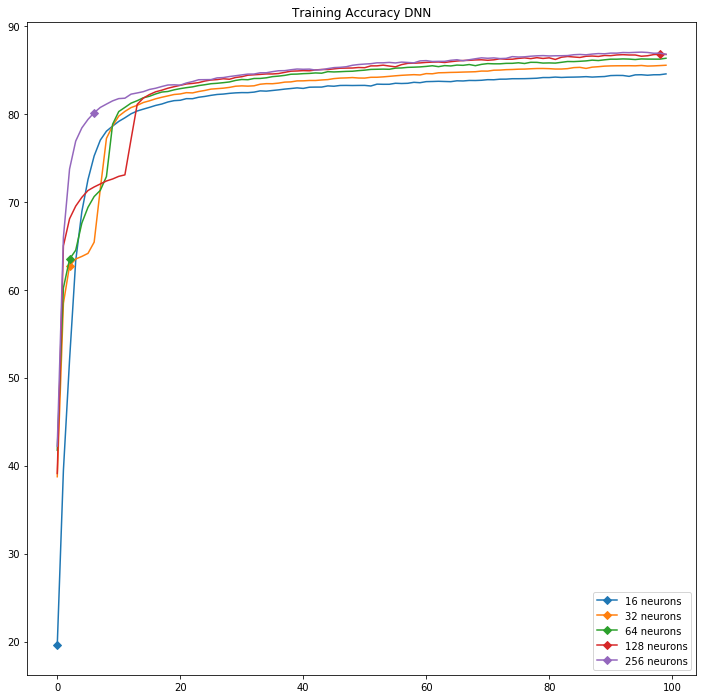

In [20]:
plt.figure(figsize=(12,12))

for i, train in enumerate(all_train):
    #plt.plot(train)
    markers_on = diversity_cosine_all[i][1:].index(max(diversity_cosine_all[i][1:]))
    plt.plot(train, '-D', markevery=[markers_on])
    plt.legend([16, 32, 64, 128])
plt.title('Training Accuracy DNN')
plt.legend(['16 neurons', '32 neurons', '64 neurons', '128 neurons', '256 neurons'])
plt.show()

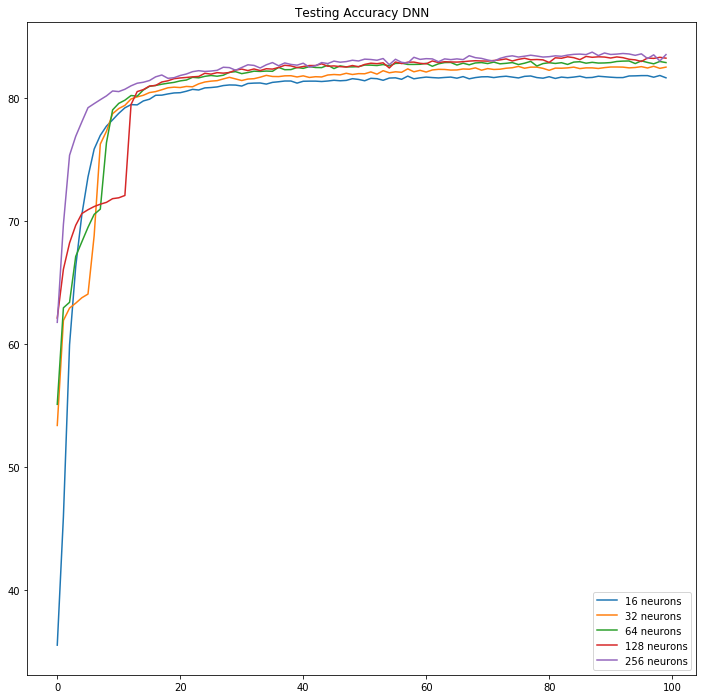

In [21]:
plt.figure(figsize=(12,12))

for test in all_test:
    plt.plot(test)
    plt.legend([16, 32, 64, 128])
plt.title('Testing Accuracy DNN')
plt.legend(['16 neurons', '32 neurons', '64 neurons', '128 neurons', '256 neurons'])
plt.show()

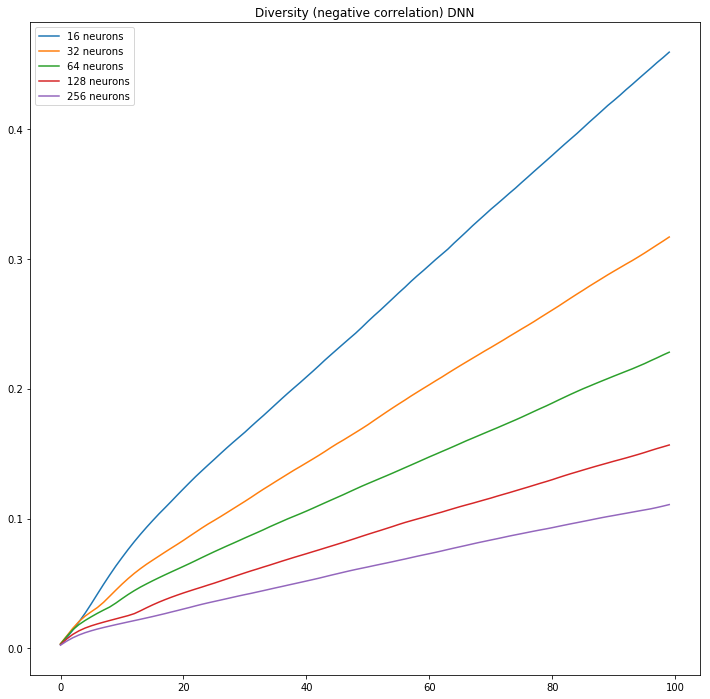

In [22]:
plt.figure(figsize=(12,12))

#ns = [16, 32, 64, 128]

for i, ncorr in enumerate(diversity_ncorr_all):
    plt.plot(np.array(ncorr)/ns[i])
plt.legend(['16 neurons', '32 neurons', '64 neurons', '128 neurons', '256 neurons'])
plt.title('Diversity (negative correlation) DNN')
#plt.savefig('Diversity_DNN_1Hidden16neurons_Reference.png')
plt.show()

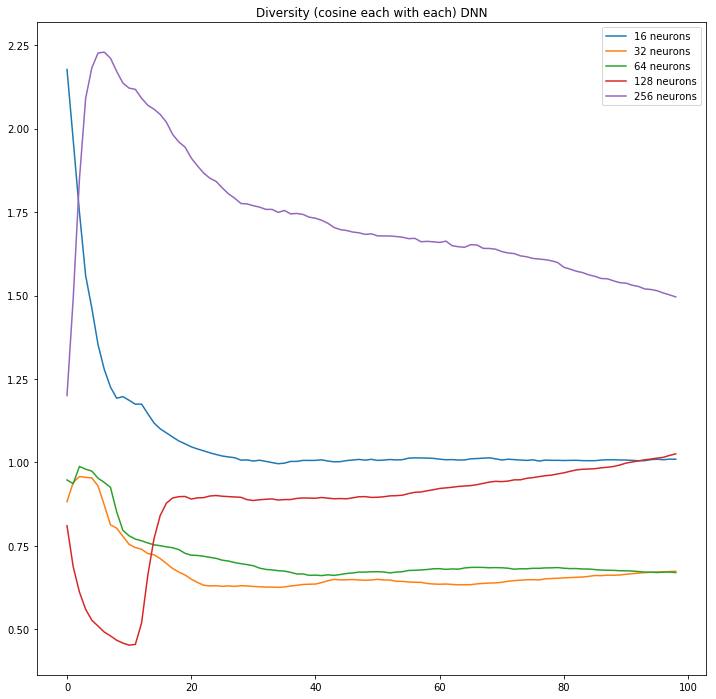

In [23]:
plt.figure(figsize=(12,12))

for i, div in enumerate(diversity_cosine_all):
    plt.plot(np.array(div[1:])/ns[i])
plt.legend(['16 neurons', '32 neurons', '64 neurons', '128 neurons', '256 neurons'])
plt.title('Diversity (cosine each with each) DNN')
#plt.savefig('Diversity_DNN_1Hidden16neurons_Reference.png')
plt.show()

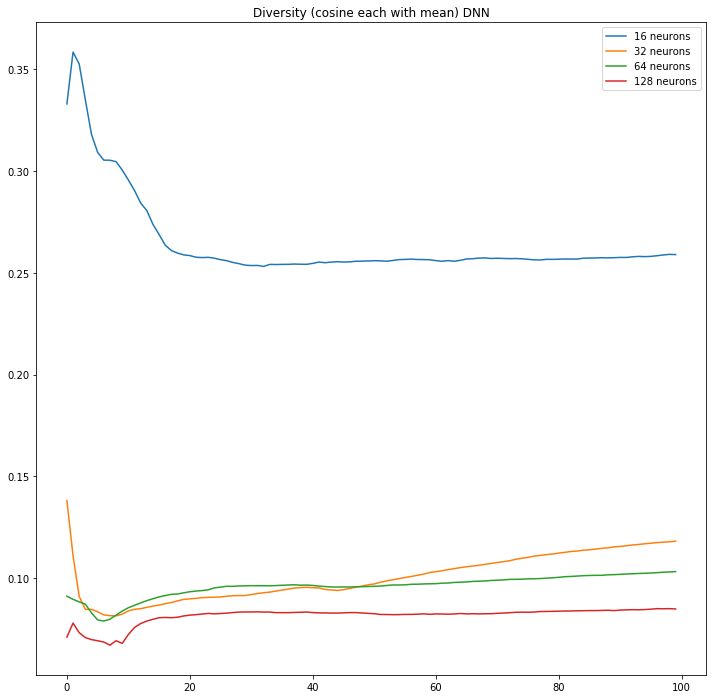

In [75]:
plt.figure(figsize=(12,12))

ns = [16, 32, 64, 128]

for i, div in enumerate(diversity_cosine_lin_all):
    plt.plot(np.array(div[1:])/ns[i])
plt.legend(['16 neurons', '32 neurons', '64 neurons', '128 neurons'])
plt.title('Diversity (cosine each with mean) DNN')
#plt.savefig('Diversity_DNN_1Hidden16neurons_Reference.png')
plt.show()

# Gradually Decrease Diversification

In [27]:
def train_gradually(model, device, train_loader, optimizer, epoch, layer, gamma=0.0, diversity = "nc", grad = 1.0):
    model.train()
    train_loss = 0
    train_correct = 0
    # mean and standard deviation
    train_mean = 0
    train_std = 0
    #diversification and loss separately
    gamma_monitor = 0
    loss_monitor = 0
    
    #if epoch <= 10:
    gamma /= grad**epoch
    #else:
        #gamma = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if diversity == 'nc':
            loss = criterion(output, target) + div_nc(layer, gamma)
        elif diversity == 'cosine':
            loss = criterion(output, target) + div_cosine(layer, gamma)
        elif diversity == 'cosine_lin':
            loss = criterion(output, target) + div_cosine_lin(layer, gamma)
        elif diversity == 'none':
            loss = criterion(output, target)
            gamma = 1
        #loss = conv_nc_2(model.hidden.weight, gamma)
        #print(model.hidden.weight.mean()*1000)
        train_mean += model.hidden.weight.mean()
        train_std += model.hidden.weight.std()
        gamma_monitor += div_nc(model.hidden.weight, gamma)
        loss_monitor += criterion(output, target)
        #print(conv_nc(model.output.weight, gamma))
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_mean /= len(train_loader.dataset)
    train_std /= len(train_loader.dataset)
    gamma_monitor /= len(train_loader.dataset)
    loss_monitor /= len(train_loader.dataset)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)
        )
    )

    return 100. * train_correct / len(train_loader.dataset), train_mean, train_std, gamma_monitor, loss_monitor

In [36]:
gammas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1]#
ns = [32]
grads = [1.0, 2.0, 4.0, 6.0, 10.0]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in grads:

        model = Network(32).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 30
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train_gradually(model,
                                                      device,
                                                      train_loader,
                                                      optimizer,
                                                      epoch,
                                                      model.hidden.weight,
                                                      gamma=g
                                                     ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 21901/60000 (37%)

Test set: Average loss: 0.0004, Accuracy: 4901/10000 (49%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 31363/60000 (52%)

Test set: Average loss: 0.0004, Accuracy: 5432/10000 (54%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 33242/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5646/10000 (56%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 35671/60000 (59%)

Test set: Average loss: 0.0004, Accuracy: 6129/10000 (61%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 37135/60000 (62%)

Test set: Average loss: 0.0004, Accuracy: 6185/10000 (62%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 38156/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6759/10000 (68%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 41564/60000 (69%)

Test set: Average loss: 0.0004, Accuracy: 6909/10000 (69%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy:


Train set: Average loss: 0.0003, Accuracy: 32941/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5396/10000 (54%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 32440/60000 (54%)

Test set: Average loss: 0.0004, Accuracy: 5632/10000 (56%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 36390/60000 (61%)

Test set: Average loss: 0.0004, Accuracy: 6481/10000 (65%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 39773/60000 (66%)

Test set: Average loss: 0.0004, Accuracy: 6630/10000 (66%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 40145/60000 (67%)

Test set: Average loss: 0.0004, Accuracy: 6669/10000 (67%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 40494/60000 (67%)

Test set: Average loss: 0.0004, Accuracy: 6707/10000 (67%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy: 40573/60000 (68%)

Test set: Average loss: 0.0004, Accuracy: 6644/10000 (66%)

Epoch #:  9

Train set: Average loss: 0.0003, Accuracy: 40777/60000


Train set: Average loss: 0.0003, Accuracy: 26222/60000 (44%)

Test set: Average loss: 0.0004, Accuracy: 4460/10000 (45%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 26922/60000 (45%)

Test set: Average loss: 0.0004, Accuracy: 4526/10000 (45%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 27236/60000 (45%)

Test set: Average loss: 0.0004, Accuracy: 4562/10000 (46%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 29637/60000 (49%)

Test set: Average loss: 0.0004, Accuracy: 5333/10000 (53%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 32516/60000 (54%)

Test set: Average loss: 0.0004, Accuracy: 5512/10000 (55%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy: 34004/60000 (57%)

Test set: Average loss: 0.0004, Accuracy: 5700/10000 (57%)

Epoch #:  9

Train set: Average loss: 0.0003, Accuracy: 35983/60000 (60%)

Test set: Average loss: 0.0004, Accuracy: 6443/10000 (64%)

Epoch #:  10

Train set: Average loss: 0.0003, Accuracy: 39359/6000

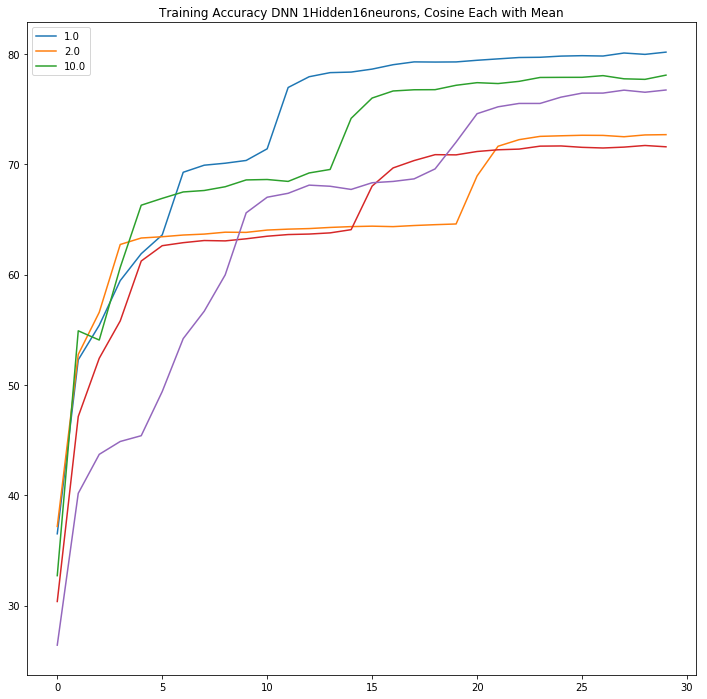

Text(0.5, 1.0, 'Test Loss DNN 1Hidden16neurons, Cosine Each with Mean')

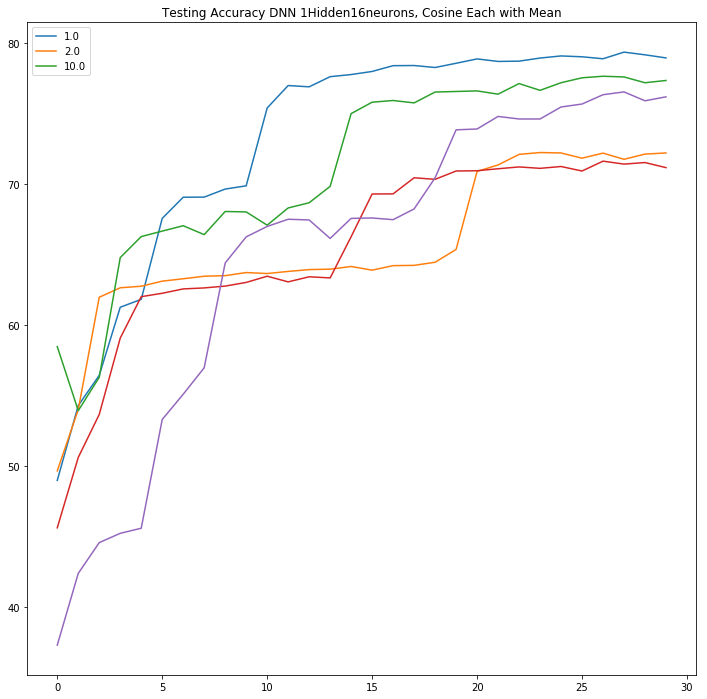

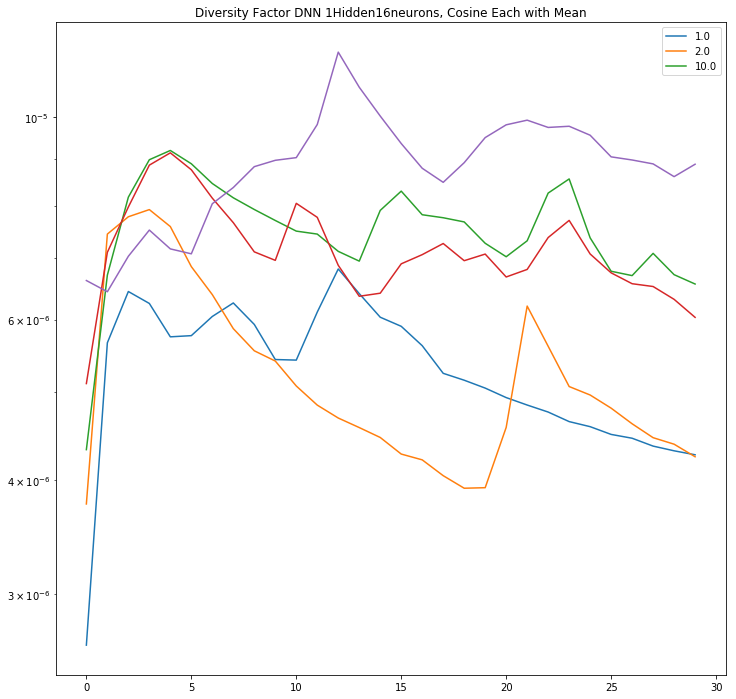

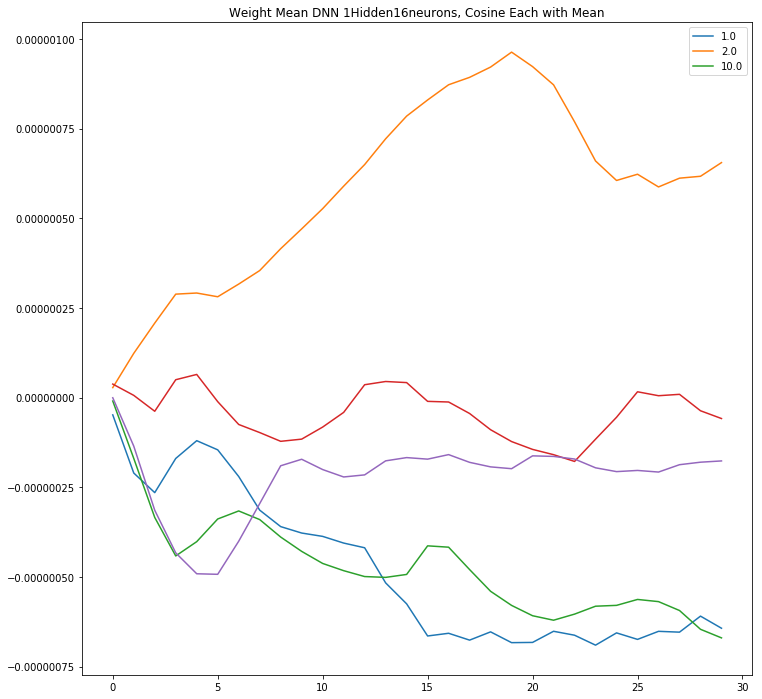

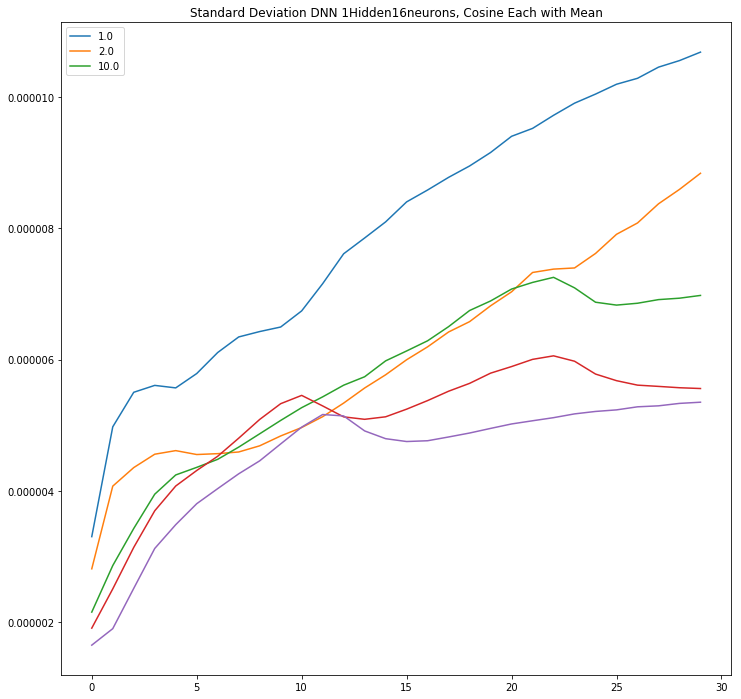

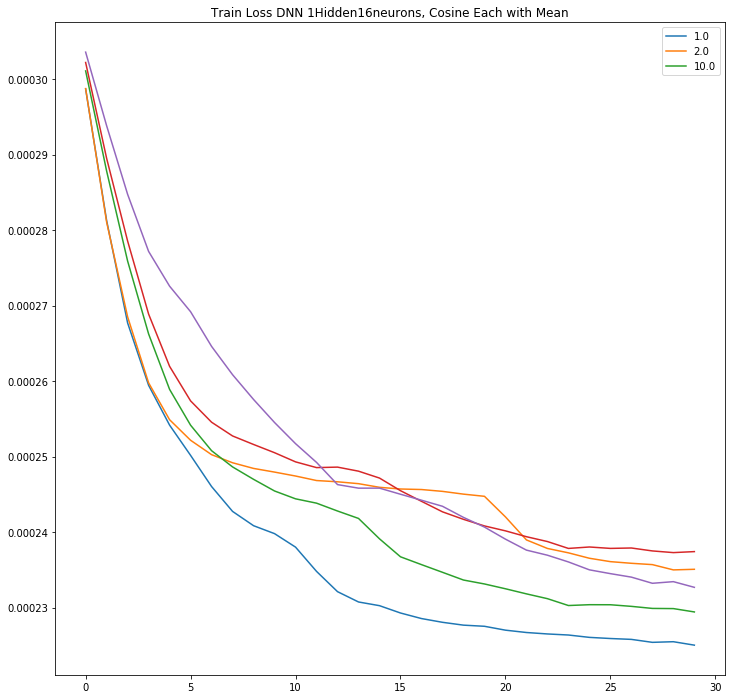

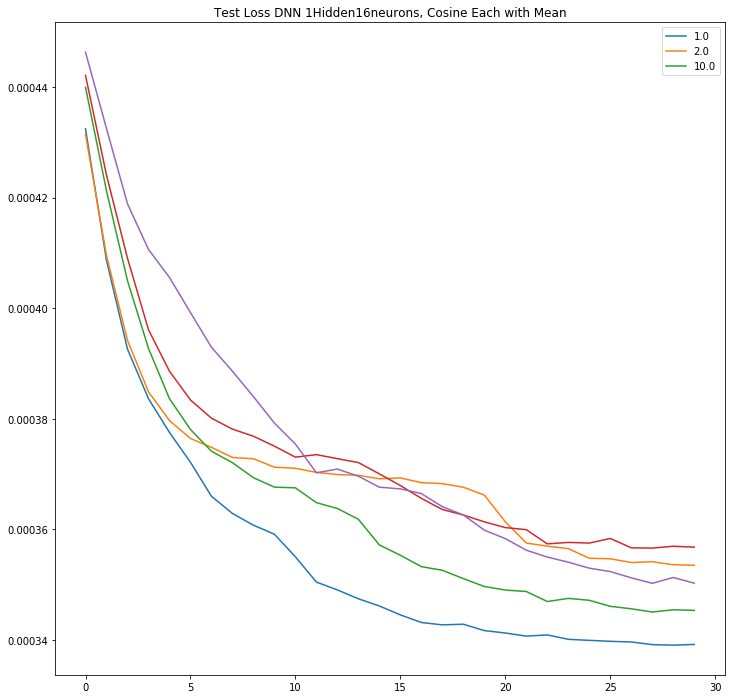

In [37]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))

for tp in train_plots:
    plt.plot(tp)
    plt.legend([1.0, 2.0, 10.0])
plt.title('Training Accuracy DNN 1Hidden16neurons, Cosine Each with Mean')
#plt.savefig('./figures/Training_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
plt.show()

plt.figure(figsize=(12,12))
for tp in test_plots:
    plt.plot(tp)
    plt.legend([1.0, 2.0, 10.0])
plt.title('Testing Accuracy DNN 1Hidden16neurons, Cosine Each with Mean')
#plt.savefig('./figures/Testing_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')

plt.figure(figsize=(12,12))
for tp in diversity[:n_pl]:
    plt.plot(tp)
    plt.legend([1.0, 2.0, 10.0])
plt.title('Diversity Factor DNN 1Hidden16neurons, Cosine Each with Mean')
#plt.savefig('./figures/Diversity_Factor_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in mean_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([1.0, 2.0, 10.0])
plt.title('Weight Mean DNN 1Hidden16neurons, Cosine Each with Mean')
#plt.savefig('./figures/Weight_Mean_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in std_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([1.0, 2.0, 10.0])
plt.title('Standard Deviation DNN 1Hidden16neurons, Cosine Each with Mean')
#plt.savefig('./figures/Standard_Deviation_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in loss_train_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([1.0, 2.0, 10.0])
plt.title('Train Loss DNN 1Hidden16neurons, Cosine Each with Mean')
#plt.savefig('./figures/Train_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([1.0, 2.0, 10.0])
plt.title('Test Loss DNN 1Hidden16neurons, Cosine Each with Mean')
#plt.savefig('./figures/Test_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #